In [16]:
!pip install intrinio-sdk
!pip install cloudstorage
!pip install webapp3

In [0]:
%load_ext google.colab.data_table

In [0]:
import logging
import os
import cloudstorage as gcs
import webapp3

from __future__ import print_function
import time
import intrinio_sdk
from intrinio_sdk.rest import ApiException
from pprint import pprint

import pandas as pd
import numpy as np
import sqlite3
from pandas.io import sql
import matplotlib.pyplot as plt

In [0]:
intrinio_sdk.ApiClient().configuration.api_key['api_key'] = API_KEY

In [0]:
securities = {'SPY': None, 'SPXL': None}

In [0]:
security_api = intrinio_sdk.SecurityApi()
for ticker in securities:
  time.sleep(60)
  identifier = ticker # str | A Security identifier (Ticker, FIGI, ISIN, CUSIP, Intrinio ID)
  tag = 'adj_close_price' # str | An Intrinio data tag ID or code reference [see - https://data.intrinio.com/data-tags]
  frequency = 'daily' # str | Return historical data in the given frequency (optional) (default to daily)
  type = '' # str | Filter by type, when applicable (optional)
  start_date = '2015-05-01' # date | Get historical data on or after this date (optional)
  end_date = '2020-05-01' # date | Get historical date on or before this date (optional)
  sort_order = 'asc' # str | Sort by date `asc` or `desc` (optional) (default to desc)
  page_size = 10000 # int | The number of results to return (optional) (default to 100)
  next_page = '' # str | Gets the next page of data from a previous API call (optional)

  try:
    api_response = security_api.get_security_historical_data(identifier, tag, frequency=frequency, type=type, start_date=start_date, end_date=end_date, sort_order=sort_order, page_size=page_size, next_page=next_page)
    securities[ticker] = pd.DataFrame.from_dict(api_response.historical_data_dict)
    #pprint(api_response)
  except ApiException as e:
    print("Exception when calling SecurityApi->get_security_historical_data: %s\r\n" % e)

In [0]:
spy = securities['SPY']
spxl = securities['SPXL']

In [0]:
df = spy.join(spxl.set_index('date'), on = "date", lsuffix='_spy', rsuffix='_spxl')

In [0]:
df['pct_change_spy']= spy.value.pct_change()
df['pct_change_spxl'] = spxl.value.pct_change()
df['daily_return_ratio'] = df['pct_change_spxl']/df['pct_change_spy']
#get rid of infinity values
df['daily_return_ratio'] = df['daily_return_ratio'].apply(lambda x: 0 if abs(x) > 1000 else x)
df['ratio_3x'] = [np.nan] + [3]*(len(df) -1)

In [0]:
adj_value = df['value_spy'][0]/df['value_spxl'][0]
df['spxl_adjusted'] = df['value_spxl'].apply(lambda x: x*adj_value)

In [27]:
df['date'] = pd.to_datetime(df.date, yearfirst=True)
df.set_index('date', inplace = True)
df.head()

,value_spy,value_spxl,pct_change_spy,pct_change_spxl,daily_return_ratio,ratio_3x,spxl_adjusted
date,,,,,,,
2015-05-01,190.685149,22.091549,NaN,NaN,NaN,NaN,190.685149
2015-05-04,191.228102,22.304036,0.002847,0.009618,3.378006,3.0,192.519248
2015-05-05,189.038191,21.520195,-0.011452,-0.035143,3.068806,3.0,185.753461
2015-05-06,188.259958,21.272294,-0.004117,-0.011519,2.798160,3.0,183.613678
2015-05-07,189.011043,21.515473,0.003990,0.011432,2.865373,3.0,185.712703


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1260 entries, 2015-05-01 to 2020-05-01
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   value_spy           1260 non-null   float64
 1   value_spxl          1260 non-null   float64
 2   pct_change_spy      1259 non-null   float64
 3   pct_change_spxl     1259 non-null   float64
 4   daily_return_ratio  1259 non-null   float64
 5   ratio_3x            1259 non-null   float64
 6   spxl_adjusted       1260 non-null   float64
dtypes: float64(7)
memory usage: 78.8 KB


In [29]:
df.describe()

,value_spy,value_spxl,pct_change_spy,pct_change_spxl,daily_return_ratio,ratio_3x,spxl_adjusted
count,1260.000000,1260.000000,1259.000000,1259.000000,1259.000000,1259.0,1260.000000
mean,239.960484,35.882511,0.000382,0.000955,3.033112,3.0,309.723057
std,41.902118,13.994283,0.011707,0.035182,2.174420,0.0,120.792884
min,168.138182,13.863586,-0.109424,-0.338719,-24.269634,3.0,119.664764
25%,199.184039,22.353616,-0.002962,-0.008802,2.817279,3.0,192.947204
50%,242.734016,34.290655,0.000505,0.001490,2.967775,3.0,295.982804
75%,272.705111,46.716529,0.004865,0.014209,3.126032,3.0,403.237830
max,336.362715,75.830000,0.090603,0.278063,34.997138,3.0,654.533323


In [30]:
df[df['pct_change_spy'] > 0.001].describe()

,value_spy,value_spxl,pct_change_spy,pct_change_spxl,daily_return_ratio,ratio_3x,spxl_adjusted
count,581.000000,581.000000,581.000000,581.000000,581.000000,581.0,581.000000
mean,242.832092,36.811771,0.007729,0.022841,2.901653,3.0,317.744045
std,42.043009,14.175634,0.008928,0.027092,0.461165,0.0,122.358236
min,171.604665,14.687563,0.001001,-0.009892,-4.655099,3.0,126.776992
25%,201.340964,22.802199,0.002667,0.008250,2.835591,3.0,196.819191
50%,246.835074,36.103876,0.005381,0.015760,2.949084,3.0,311.633781
75%,274.498548,47.265494,0.009492,0.028251,3.049887,3.0,407.976270
max,336.362715,75.830000,0.090603,0.278063,4.006437,3.0,654.533323


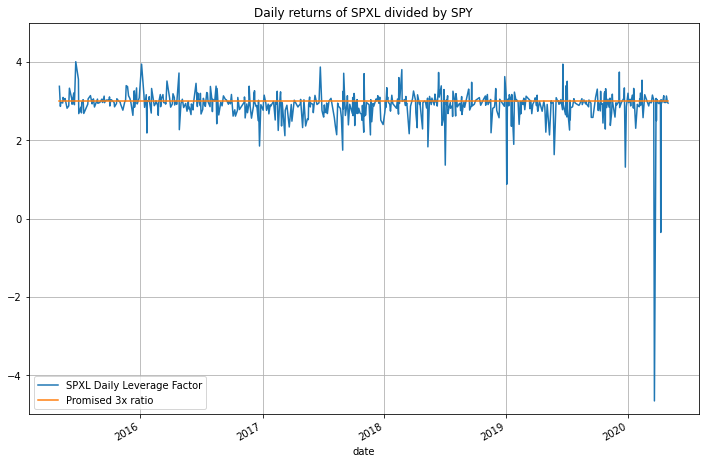

In [47]:
sig_change_df = df[df['pct_change_spy'] > 0.001]
fig, ax = plt.subplots()
sig_change_df[['daily_return_ratio', 'ratio_3x']].plot(kind='line', title = 'Daily returns of SPXL divided by SPY', legend= True, figsize = (12, 8), grid = True, ylim= (-5,5), ax = ax)
ax.legend(['SPXL Daily Leverage Factor', 'Promised 3x ratio'], loc = 3)

In [35]:
len(sig_change_df[sig_change_df['daily_return_ratio'] < 0])

2

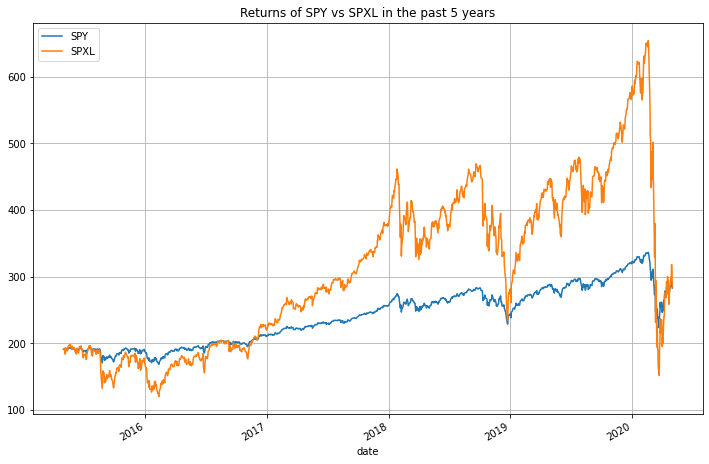

In [36]:
fig, ax = plt.subplots()
df[['value_spy', 'spxl_adjusted']].plot(kind='line', title = 'Returns of SPY vs SPXL in the past 5 years', legend= True, figsize = (12, 8), grid = True, ax = ax)
ax.legend(['SPY', 'SPXL'])

In [37]:
print(f"SPY returns in five years: {df.value_spy[-1]*100/df.value_spy[0]}%")
print(f"SPXL returns in five years: {df.value_spxl[-1]*100/df.value_spxl[0]}%")

SPY returns in five years: 148.3020581253211%
SPXL returns in five years: 149.33312443768332%


In [51]:
print(f"SPY returns at the start of 2020: {df.value_spy[pd.DatetimeIndex(['2020-01-02'])]*100/df.value_spy[0]}%")
print(f"SPXL returns at the start of 2020: {df.value_spxl[pd.DatetimeIndex(['2020-01-02'])]*100/df.value_spxl[0]}%")

SPY returns at the start of 2020: 2020-01-02    169.374195
Name: value_spy, dtype: float64%
SPXL returns at the start of 2020: 2020-01-02    307.402621
Name: value_spxl, dtype: float64%


In [53]:
print(f"SPY sharpe ratio: {1.48302/df.value_spy.std()}")
print(f"SPXL sharpe ratio: {1.49333/df.spxl_adjusted.std()}")

SPY sharpe ratio: 0.035392482951091854
SPXL sharpe ratio: 0.012362731522721639


In [0]:
max_drawdown_spxl = 0
max_drawdown_spy = 0
for index, row in df[['value_spy', 'spxl_adjusted']].iterrows():
  if index ==pd.DatetimeIndex(['2015-05-01']):
    max_spxl = row['spxl_adjusted']
    max_spy = row['value_spy']
    min_spxl = row['spxl_adjusted']
    min_spy = row['value_spy']
    
    continue
  if row['spxl_adjusted'] > max_spxl:
    max_spxl = row['spxl_adjusted']
    min_spxl= row['spxl_adjusted']
  
  if row['value_spy'] > max_spy:
    max_spy = row['value_spy']
    min_spy = row['value_spy']   

  max_spxl = max(max_spxl, row['spxl_adjusted'])
  max_spy = max(max_spy, row['value_spy'])
  min_spxl = min(min_spxl, row['spxl_adjusted'])
  min_spy = min(min_spy, row['value_spy'])

  max_drawdown_spxl = max(max_drawdown_spxl, (max_spxl - min_spxl)*100/max_spxl)
  max_drawdown_spy = max(max_drawdown_spy, (max_spy - min_spy)*100/max_spy)
  

In [39]:
print(f"Maximum Drawdown of SPXL: {max_drawdown_spxl}")
print(f"Maximum Drawdown of SPY: {max_drawdown_spy}")

76.85612554397994

In [0]:
df['rolling_spy'] = df['value_spy'].rolling(20).mean()
df['rolling_vol'] = df['value_spy'].rolling(20).std()
df['rolling_spxl'] = df['spxl_adjusted'].rolling(20).mean()

#df['spy_rolling_returns'] = df['value_spy'].pct_change(periods = 19)
#df['spxl_rolling_return'] = df['value_spxl'].pct_change(periods = 19)
df['spxl_performance'] = df['rolling_spxl'] - df['rolling_spy']

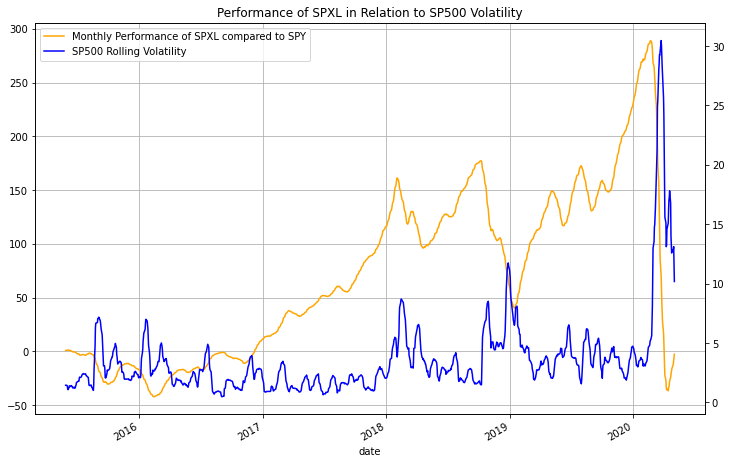

In [45]:
plt.figure(figsize=(12,8))
plt.xlabel('Performance of SPXL in Relation to SP500 Volatility')
plt.title('Performance of SPXL in Relation to SP500 Volatility')
ax1 = df.spxl_performance.plot(color='orange', grid=True, label='Monthly Performance of SPXL compared to SPY')
ax2 = df.rolling_vol.plot(color='blue', grid=True, secondary_y=True, label='SP500 Rolling Volatility')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()